## Install and import

In [2]:
# !pip install torch==1.4.0
# !pip install transformers==2.11.0
# !pip install attrdict==2.0.1
!pip install datasets transformers attrdict

     |████████████████████████████████| 225kB 4.4MB/s 
     |████████████████████████████████| 2.1MB 7.1MB/s 
     |████████████████████████████████| 112kB 13.6MB/s 
     |████████████████████████████████| 245kB 17.0MB/s 
     |████████████████████████████████| 3.3MB 21.6MB/s 
     |████████████████████████████████| 901kB 50.3MB/s 


In [3]:
import torch
import torch.nn as nn
from transformers import BertPreTrainedModel, BertModel
from transformers import BertTokenizer
from typing import Union, Optional

import numpy as np
from transformers.pipelines import ArgumentHandler
from transformers import (
    Pipeline,
    PreTrainedTokenizer,
    ModelCard
)
from pprint import pprint
import os
import google.colab as colab
import pandas as pd
import json
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt

In [4]:
def mount_google_drive():
	'''
	# Functionality
		Mount google drive. Since colab does not save files, we want to make it easier to directly access files in google drive.
	# Arguments
		Nothing
	# Returns
		drive_root: the working directory mounted
	'''
	mount_directory = "/content/gdrive"
	drive = colab.drive
	drive.mount(mount_directory, force_remount=True)
	drive_root = mount_directory + "/" + list(filter(lambda x: x[0] != '.', os.listdir(mount_directory)))[0]
	return drive_root

ROOT_DIR =  mount_google_drive() + "/goemotion/"
CHECKPOINT_ROOT = ROOT_DIR+ "goemotion-ckpt/original/checkpoint-10000"

Mounted at /content/gdrive


## Model Class

In [5]:
class BertForMultiLabelClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, self.config.num_labels)
        self.loss_fct = nn.BCEWithLogitsLoss()

        self.init_weights()

    def forward(
            self,
            input_ids=None,
            attention_mask=None,
            token_type_ids=None,
            position_ids=None,
            head_mask=None,
            inputs_embeds=None,
            labels=None,
    ):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )
        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

        if labels is not None:
            loss = self.loss_fct(logits, labels)
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

# Retrieval helpers

In [6]:
def generate_candidates(test_sents):
  # simplest case: just flip the sentences
  return test_sents[::-1]

# Inference On Testset

In [11]:
device = 0
threshold = 0.3
tokenizer = BertTokenizer.from_pretrained(CHECKPOINT_ROOT)
model = BertForMultiLabelClassification.from_pretrained(CHECKPOINT_ROOT)
model = model.to(device)

# goemotions = MultiLabelPipeline(
#     model=model,
#     tokenizer=tokenizer,
#     threshold=0.3
# )

def goemotions(texts):
  torch.cuda.set_device(device)
  # 1. Tokenizer pass for both test inputs and candidate inputs
  inputs = tokenizer(
            texts,
            add_special_tokens=True,
            return_tensors="pt",
            padding=True,
            truncation=False,
        )
  with torch.no_grad():
    # 2. Model Forward pass
    inputs = {name: tensor.to(device) for name, tensor in inputs.items()}
    # outputs = model(**inputs)[0].cpu()
    outputs = model(input_ids=inputs["input_ids"],
                    attention_mask=inputs["attention_mask"],
                    token_type_ids=inputs["token_type_ids"])[0].cpu()
    # 3. Inference output post-processing
    scores = 1 / (1 + np.exp(-outputs))  # Sigmoid
    results = []
    for item in scores:
        labels = []
        scores = []
        for idx, s in enumerate(item):
            if s > threshold:
                labels.append(model.config.id2label[idx])
                scores.append(float(s))
        results.append({"labels": labels, "scores": scores})
    return results

texts = [
    "Hey that's a thought! Maybe we need [NAME] to be the celebrity vaccine endorsement!",
    "it’s happened before?! love my hometown of beautiful new ken 😂😂",
    "I love you, brother.",
    "Troll, bro. They know they're saying stupid shit. The motherfucker does nothing but stink up libertarian subs talking shit",
]

pprint(goemotions(texts))

# Output
#  [{'labels': ['neutral'], 'scores': [0.9750906]},
#  {'labels': ['curiosity', 'love'], 'scores': [0.9694574, 0.9227462]},
#  {'labels': ['love'], 'scores': [0.993483]},
#  {'labels': ['anger'], 'scores': [0.99225825]}]

# [{'labels': ['optimism'], 'scores': [0.3206218481063843]},
#  {'labels': ['curiosity', 'love'],
#   'scores': [0.4122002422809601, 0.8766248226165771]},
#  {'labels': ['love'], 'scores': [0.9667580723762512]},
#  {'labels': ['anger'], 'scores': [0.9185698628425598]}]

{'input_ids': tensor([[  101,  4403,  1115,   112,   188,   170,  1354,   106,  2389,  1195,
          1444,     1,  1106,  1129,  1103, 10948, 20034, 22843,   106,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  1122,   787,   188,  2171,  1196,   136,   106,  1567,  1139,
          9694,  1104,  2712,  1207,   180,  1424,   100,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101,   146,  1567,  1128,   117,  1711,   119,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101,   157, 10747,   117,  9304,  1186,   119,  1220,  1221,  1152,
           112,  1231,  2157,  4736,  4170,   119,  1109,  15

In [8]:
inputs = tokenizer(
            texts,
            add_special_tokens=True,
            return_tensors="pt",
            padding=True,
            truncation=False,
        )

print(inputs.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


## Load Test set and true labels

In [ ]:
# Load labels and build dicts
with open(ROOT_DIR + "data/original/labels.txt", "r") as f:
  labels = f.read().splitlines()
label2index = {v: k for k, v in enumerate(labels)}
index2label = {k: v for k, v in enumerate(labels)}


# Load test set, get test sents and ground truths
df = pd.read_csv(ROOT_DIR + "data/original/test.tsv", sep='\t', header=None, names=["sentence", "label", "encoding"])
sentences = df.sentence.tolist()
ground_truths = []
for x in df.label.tolist():
  single_idxs = x.split(",")
  single_labels = []
  for label in single_idxs:
    single_labels.append(index2label[int(label)])
  ground_truths.append(single_labels)

In [ ]:
# raw_predictions = []
# batch_size = 81
# num_batches = len(sentences) / batch_size

# i = 0
# while i < len(sentences):
#   raw_predictions += goemotions(sentences[i: i + batch_size])
#   i = i + batch_size

# with open(ROOT_DIR + "data/original/predictions_epoch4.json", 'w') as f:
#   json.dump(raw_predictions, f)

In [ ]:
with open(ROOT_DIR + "data/original/predictions_epoch4.json", 'r') as f:
  raw_predictions = json.load(f)

In [ ]:
predictions = [x["labels"] for x in raw_predictions]

In [ ]:
len(ground_truths) == len(predictions)

True

In [ ]:
num_em = 0
for i, (pred, truth) in enumerate(zip(predictions, ground_truths)):
  if pred != truth and "grief" in truth:
    num_em += 1
    print(sentences[i])
    print(pred)
    print(truth)
    print("------------------")
# print(num_em / len(predictions))

[NAME] death is just so..... senseless. Why? WHY??? The based gods have forsaken us
[]
['grief']
------------------
Rip the guy from psych
['neutral']
['grief']
------------------
The only death that made me feel any emotion. And it wasn’t even the death itself.
['neutral']
['grief', 'sadness']
------------------
My condolences.
['sadness']
['grief', 'sadness']
------------------
Oh my gosh. This woman who died also had a son who died. Holy tragedy
['sadness', 'surprise']
['grief', 'sadness', 'surprise']
------------------
You'll miss a begging old man asking for a spare coin. RIP
['neutral']
['grief', 'sadness']
------------------


In [ ]:
num_em = 0
for i, (pred, truth) in enumerate(zip(predictions, ground_truths)):
  if pred != truth and "pride" in truth:
    num_em += 1
    print(sentences[i])
    print(pred)
    print(truth)
    print("------------------")
# print(num_em / len(predictions))

I only eat cronuts cuz I'm sophisticated!
['approval']
['pride']
------------------
This internet stranger is also super proud of you! Way to go!!!
['admiration', 'excitement']
['admiration', 'pride']
------------------
That’s better:-) now go get em tiger
['approval', 'neutral']
['approval', 'optimism', 'pride']
------------------
My jersey has the great number 10 on it!!
['admiration']
['pride']
------------------
And I taught my room was dirty and that I was not taking care of my self. Good job op
['admiration']
['admiration', 'pride']
------------------
I am proud of you random internet stranger, you peopled good today.
['admiration']
['admiration', 'pride']
------------------
That's nothing, before BSE we did horrible things with bone meal animal feed. Cannibal cows.
['disapproval']
['pride']
------------------
Yep. I did this in uni, got mad respect for holding my "booze". 
['admiration', 'approval']
['pride']
------------------
You’re doing so good! We’re all so proud!
['admirat

In [ ]:
num_em = 0
for i, (pred, truth) in enumerate(zip(predictions, ground_truths)):
  if pred != truth and "relief" in truth:
    num_em += 1
    print(sentences[i])
    print(pred)
    print(truth)
    print("------------------")
# print(num_em / len(predictions))

Resetting a dislocated knee hurts like hell but it feels a lot better immediately after.
['caring']
['relief']
------------------
Praise the [NAME] for REALITY! WOOF!!!!!
['admiration']
['relief']
------------------
I'm glad you have someone to help you out! Perhaps over time you'll find it easier.
['caring', 'joy']
['joy', 'relief']
------------------
I’ve exposed on social media. It made me feel better so I don’t care what anyway has to say about it.
['approval', 'realization']
['relief']
------------------
at least it wasn’t the evil [NAME].
['neutral']
['relief']
------------------
Yay, coming out is hard, you're lucky that they didnt avoid you for the next month, I'm happy for you
['joy']
['caring', 'joy', 'relief']
------------------
I'm glad it only sprayed soda when his thumb went into the can, and not blood everywhere.
['joy']
['relief']
------------------
Glad I'm not the only one
['joy']
['joy', 'relief']
------------------
This is really helpful to point out!!
['approval', 

In [ ]:
def convert_onehot(inputs):
  final_arr = np.zeros((len(inputs), len(label2index.keys())))
  for i, labels in enumerate(inputs):
    for label in labels:
      final_arr[i, label2index[label]] = 1
  return final_arr

In [ ]:
onehot_truths = convert_onehot(ground_truths)
onehot_preds = convert_onehot(predictions)

In [ ]:
multilabel_confmat = multilabel_confusion_matrix(onehot_truths, onehot_preds)

In [ ]:
cls_report = {}
for i in range(multilabel_confmat.shape[0]):
  cls_report[index2label[i]] = {}
  cls_report[index2label[i]]["tn"] = multilabel_confmat[i, 0, 0] + 0.01
  cls_report[index2label[i]]["fp"] = multilabel_confmat[i, 0, 1] + 0.01
  cls_report[index2label[i]]["fn"] = multilabel_confmat[i, 1, 0] + 0.01
  cls_report[index2label[i]]["tp"] = multilabel_confmat[i, 1, 1] + 0.01
  cls_report[index2label[i]]["total"] = cls_report[index2label[i]]["tp"] + cls_report[index2label[i]]["fn"]
  cls_report[index2label[i]]["precision"] = cls_report[index2label[i]]["tp"] / (cls_report[index2label[i]]["fp"] + cls_report[index2label[i]]["tp"])
  cls_report[index2label[i]]["recall"] = cls_report[index2label[i]]["tp"] / (cls_report[index2label[i]]["fn"] + cls_report[index2label[i]]["tp"])
  cls_report[index2label[i]]["f1"] = 2 * cls_report[index2label[i]]["precision"] * cls_report[index2label[i]]["recall"] / (cls_report[index2label[i]]["precision"] + cls_report[index2label[i]]["recall"])

In [ ]:
cls_report

{'admiration': {'f1': 0.6660687009342474,
  'fn': 129.01,
  'fp': 247.01,
  'precision': 0.6028905822963891,
  'recall': 0.7440379350025793,
  'tn': 4676.01,
  'total': 504.02,
  'tp': 375.01},
 'amusement': {'f1': 0.8095842480790341,
  'fn': 28.01,
  'fp': 83.01,
  'precision': 0.7397968779386872,
  'recall': 0.8939095523066435,
  'tn': 5080.01,
  'total': 264.02,
  'tp': 236.01},
 'anger': {'f1': 0.5059096066565809,
  'fn': 91.01,
  'fp': 118.01,
  'precision': 0.4755577282019376,
  'recall': 0.5403999596000404,
  'tn': 5111.01,
  'total': 198.02,
  'tp': 107.01},
 'annoyance': {'f1': 0.3688836378306726,
  'fn': 192.01,
  'fp': 246.01,
  'precision': 0.3422544248970643,
  'recall': 0.4000062496093994,
  'tn': 4861.01,
  'total': 320.02,
  'tp': 128.01},
 'approval': {'f1': 0.3920057596928163,
  'fn': 204.01,
  'fp': 252.01,
  'precision': 0.3684276477369555,
  'recall': 0.41880804512563385,
  'tn': 4824.01,
  'total': 351.02,
  'tp': 147.01},
 'caring': {'f1': 0.4421133875947235,
  '

In [ ]:
def get_attr_class(cls_report, metric_name):
  return [x[metric_name] for x in list(cls_report.values())]

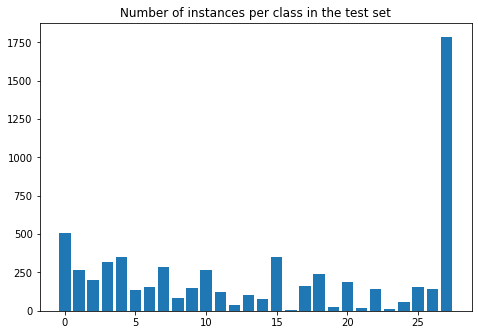

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Number of instances per class in the test set')
metric_name = "total"
ax.bar(list(label2index.values()), [x[metric_name] for x in list(cls_report.values())])
plt.show()

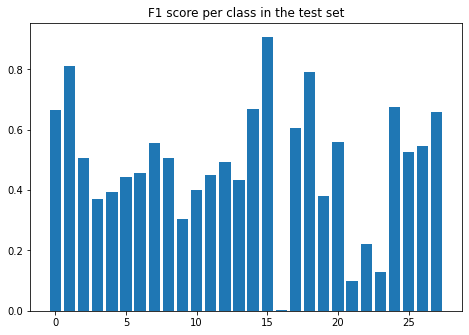

In [ ]:
# make two columns
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('F1 score per class in the test set')
metric_name = "f1"
ax.bar(list(label2index.values()), [x[metric_name] for x in list(cls_report.values())])
plt.show()